# libraries and imports

library to scrape sec edgar website
https://github.com/coyo8/sec-edgar

In [1]:
import pandas as pd
#import regex as re
import datetime
#import os 
import numpy as np

In [2]:
# import libraries and modules
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Import data

In [3]:
# cluster
#['aapl' 'amzn' 'csco' 'ebay' 'fcbk' 'msft']

In [4]:
aapl=pd.read_csv('../csv/aapl_8.csv', index_col=0)
#goog=pd.read_csv('../csv/goog_8.csv', index_col=0)
msft=pd.read_csv('../csv/msft_8.csv', index_col=0)
#adbe=pd.read_csv('../csv/adbe_8.csv', index_col=0)
#akam=pd.read_csv('../csv/akam_8.csv', index_col=0)
fcbk=pd.read_csv('../csv/fcbk_8.csv', index_col=0)
amzn=pd.read_csv('../csv/amzn_8.csv', index_col=0)
#ibm=pd.read_csv('../csv/ibm_8.csv', index_col=0)
#intc=pd.read_csv('../csv/intc_8.csv', index_col=0)
csco=pd.read_csv('../csv/csco_8.csv', index_col=0)
#ea=pd.read_csv('../csv/ea_8.csv', index_col=0)
ebay=pd.read_csv('../csv/ebay_8.csv', index_col=0)

In [5]:
comps = aapl
#comps = aapl.append(goog, ignore_index=True, sort=None)
comps = comps.append(msft, ignore_index=True, sort=None)
#comps = comps.append(adbe, ignore_index=True, sort=None)
#comps = comps.append(akam, ignore_index=True, sort=None)
comps = comps.append(fcbk, ignore_index=True, sort=None)
comps = comps.append(amzn, ignore_index=True, sort=None)
#comps = comps.append(ibm, ignore_index=True, sort=None)
#comps = comps.append(intc, ignore_index=True, sort=None)
comps = comps.append(csco, ignore_index=True, sort=None)
#comps = comps.append(ea, ignore_index=True, sort=None)
comps = comps.append(ebay, ignore_index=True, sort=None)
comps.to_csv('../csv/stocks.csv')

In [6]:
# comps['date'] = pd.to_datetime(comps['date'])

In [7]:
# sort by date so that companies are shuffled (test not based on few companies not in train)
comps.sort_values(by=['date'],inplace=True)
comps.head(1)

,date,ticker,neg_text,uncert_text,pos_text,delta_0_p,delta_1_p,delta_1_0,delta_3_np,delta_7_np,delta_3_n0,delta_7_n0,period,an_buy,an_hold,an_sell,an_rating,an_d_p,an_d_0
253,2009-04-17,amzn,against break challenge challenges closure con...,appear believe could differ may might pending ...,able achieving advantage advantages benefit be...,1,1,0,0,0,1,0,6.0,9.0,20.0,3.0,3.406,1,1


In [8]:
comps.reset_index(inplace=True)

In [9]:
# works
#comps['date'][400:]

In [10]:
# comps.reset_index(drop=True)
# comps.set_index('date', inplace=True)
#comps.info()

#### Check Data

In [11]:
comps.ticker.unique()

array(['amzn', 'ebay', 'aapl', 'msft', 'fcbk', 'csco'], dtype=object)

## Prepare data for right format

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
tickers = comps.ticker
ticker_encoder = LabelEncoder()
ticker_encoded = ticker_encoder.fit_transform(tickers)

In [13]:
comps['ticker'] = ticker_encoded

In [14]:
comps['ticker'].unique()

array([1, 3, 0, 5, 4, 2])

In [15]:
comps.tail(105)['ticker'].unique()

array([3, 4, 5, 2, 1, 0])

## Model

### Features and Target

In [16]:
# set text feature and target
X = comps['neg_text'] #alternatively: pos_text uncert_text
y = comps['delta_7_np']
#y = pd.DataFrame(y)

### Train-test-split

In [17]:
comps.shape

(524, 20)

In [18]:
y.tail(3)

521    1
522    1
523    1
Name: delta_7_np, dtype: int64

In [19]:
# X_train = X.head(419)
# y_train = y.head(419)
# X_test = X.tail(105)
# y_test = y.tail(105)

In [20]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    shuffle=False
                                                   )

In [21]:
# X_test.index[0:5]

In [22]:
X_train.index, X_test.index

(Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
             ...
             409, 410, 411, 412, 413, 414, 415, 416, 417, 418],
            dtype='int64', length=419),
 Int64Index([419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
             ...
             514, 515, 516, 517, 518, 519, 520, 521, 522, 523],
            dtype='int64', length=105))

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((419,), (419,), (105,), (105,))

### Classifers and Vectorizers

In [24]:
# vectorizer initialized (also see GS 506)
tf = CountVectorizer()
#tf = TfidfVectorizer()
nb = BernoulliNB()
lr = LogisticRegression()
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()
bag = BaggingClassifier()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
svc = svm.SVC()

In [25]:
#X_train_tf.isnull().sum().sum(), X_test_tf.isnull().sum().sum()

In [26]:
# muted because will be fit within the pipeline
# Fit our CountVectorizer on the training data and transform training data.
X_train_tf = pd.DataFrame(tf.fit_transform(X_train).todense(),
                            columns = tf.get_feature_names())

# Transform our testing data with the already-fit CountVectorizer
X_test_tf = pd.DataFrame(tf.transform(X_test).todense(),
                            columns = tf.get_feature_names())

In [27]:
X_train = X_train_tf
X_test = X_test_tf

In [28]:
comps[comps.index.isin(X_test.index)]['ticker'].unique()

array([1, 3, 0, 5, 4])

In [29]:
X_train['ticker'] = comps[comps.index.isin(X_train.index)]['ticker']
X_test['ticker'] = comps[comps.index.isin(X_test.index)]['ticker']
X_train.isnull().sum().sum()

0

In [30]:
X_test.ticker.unique()

array([1, 3, 0, 5, 4])

In [31]:
X_test.ticker.value_counts()

1    34
3    29
5    19
0    18
4     5
Name: ticker, dtype: int64

In [32]:
X_test.ticker.unique()

array([1, 3, 0, 5, 4])

### Baseline prediction

In [33]:
round(max(comps['delta_7_np'].value_counts(normalize=True)*100),2)

58.97

### Main Model

In [34]:
model = BernoulliNB()
model.fit(X_train, y_train)
round(pd.Series({'Test': model.score(X_test, y_test)*100, 'Train': model.score(X_train, y_train)*100}),2)

Test     67.62
Train    63.48
dtype: float64

### Other Models

In [35]:
# No scaling
def score(model):
    model= model

    model.fit(X_train, y_train)
    return model.score(X_test, y_test), model.score(X_train, y_train)

scores = pd.DataFrame({'NB': score(nb), 'LR': score(lr), 'KNN':score(knn), 'Decision Trees': score(tree),
              'Bagging': score(bag), 'Random Forest': score(rf), 
              'Extra Tree': score(et),
              'Adaboost': score(ada), 'SVC': score(svc)}, 
             index=['test', 'train'])
scores.sort_values('test',axis=1, ascending=False)

/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,NB,SVC,Adaboost,Random Forest,KNN,Decision Trees,LR,Bagging,Extra Tree
test,0.676190,0.657143,0.628571,0.533333,0.523810,0.523810,0.514286,0.447619,0.409524
train,0.634845,0.572792,0.916468,0.897375,0.701671,0.916468,0.816229,0.894988,0.916468


### Scale

In [36]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

def model_score(model):
    model_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('model', model)
    ])

    model_pipe.fit(X_train_sc, y_train)
    return model_pipe.score(X_test_sc, y_test), model_pipe.score(X_train_sc, y_train)

scores = pd.DataFrame({'NB': score(nb),'LR': model_score(lr), 'KNN':model_score(knn), 'Decision Trees': model_score(tree),
              'Bagging': model_score(bag), 'Random Forest': model_score(rf), 'Extra Tree': model_score(et),
              'Adaboost': model_score(ada), 'SVC': model_score(svc)}, 
             index=['test_sc', 'train_sc'])
scores.sort_values('test_sc',axis=1, ascending=False)

,NB,SVC,Adaboost,LR,KNN,Decision Trees,Bagging,Extra Tree,Random Forest
test_sc,0.676190,0.666667,0.609524,0.590476,0.580952,0.495238,0.485714,0.485714,0.466667
train_sc,0.634845,0.673031,0.916468,0.856802,0.663484,0.916468,0.897375,0.916468,0.890215


### Confusion Matrix

In [37]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
cm

array([[ 7, 29],
       [ 5, 64]])

In [38]:
cm_df = pd.DataFrame(data=cm, columns=['predicted gain', 'predicted loss'], index=['actual gain', 'actual loss'])
cm_df

,predicted gain,predicted loss
actual gain,7,29
actual loss,5,64


Text(33.0, 0.5, 'true values')

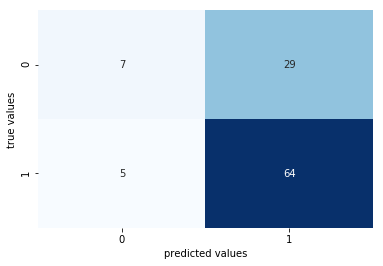

In [39]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('predicted values')
plt.ylabel('true values')

In [40]:
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
spec = tn / (tn + fp)
sens = tp / (tp + fn)
accu = (tp+tn)/(tp+tn+fp+fn)
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print(f'Sensitivity: {round(sens,4)}')
print(f'Specificity: {round(spec,4)}')
print(f'Accuracy: {round(accu,4)}')

True Negatives: 7
False Positives: 29
False Negatives: 5
True Positives: 64
Sensitivity: 0.9275
Specificity: 0.1944
Accuracy: 0.6762


### Predictions

In [41]:
X_test.ticker.unique()

array([1, 3, 0, 5, 4])

In [42]:
# y_test = y_test.reset_index().drop(columns="index")
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0:'pred'}, inplace=True)
predictions['true'] = y_test.values
predictions['ticker'] = X_test['ticker']
true_values = pd.DataFrame(y_test)

In [43]:
off_preds = pd.DataFrame(predictions[predictions['pred'] != predictions['true']])
off_preds

,pred,true,ticker
0,0,1,1
5,0,1,1
7,1,0,1
9,1,0,1
18,1,0,3
21,0,1,1
24,1,0,1
28,1,0,3
29,1,0,1
31,1,0,5


In [44]:
predictions.shape, true_values.shape

((105, 3), (105, 1))

In [45]:
predictions.to_csv('../csv/stocks_preds.csv')
true_values.to_csv('../csv/stocks_true.csv')

In [46]:
true_values = pd.read_csv('../csv/stocks_true.csv', index_col=0) #
true_values.shape

(105, 1)

In [47]:
predictions = pd.read_csv('../csv/stocks_preds.csv',index_col=0)

In [48]:
predictions.ticker.unique()

array([1, 3, 0, 5, 4])

In [49]:
true_values.head()

,delta_7_np
419,1
420,1
421,1
422,1
423,1
